# 3D covolution for the classification of inlay and onlay tooth using using neural network

Introduction to Neural Network Transfer Learning for Digital Partial Dental Crown Synthesis

In the realm of computer-aided design for dental restorations, the synthesis of partial dental crowns requires accurate and robust models capable of generating precise three-dimensional representations. However, obtaining large-scale datasets for training such models can often be a challenging task in the field of dentistry. To overcome this limitation, transfer learning, a powerful technique in the domain of deep learning, can be employed to leverage pre-existing knowledge from related domains.

In this research paper titled "Computer-aided design and 3-dimensional artificial/convolutional neural network for digital partial dental crown synthesis and validation," we address the scarcity of dental-specific data by harnessing transfer learning on a pre-trained model originally trained on CT scans which was imported from the [following work](https://keras.io/examples/vision/3D_image_classification/). This approach enables us to transfer knowledge from the rich domain of medical imaging to the task of dental crown synthesis.

Transfer learning involves utilizing the knowledge captured by a neural network trained on a large-scale dataset to improve performance on a different, but related, task. By employing a pre-trained model on CT scans, which shares commonalities with dental radiographs and images, we can leverage the learned features and hierarchical representations to boost the performance of our dental crown synthesis model.

The transfer learning process involves freezing the early layers of the pre-trained model, which capture general image features, and fine-tuning the latter layers to adapt to the dental crown synthesis task. This allows our neural network to focus on learning dental-specific patterns and intricacies, while still benefiting from the initial knowledge acquired from the CT scans.

By employing transfer learning, we aim to enhance the accuracy and efficiency of our digital partial dental crown synthesis model, despite having limited dental-specific training data. Leveraging the pre-trained model's ability to extract relevant features, we can potentially overcome the data scarcity challenge and improve the quality of synthesized dental crowns.

Throughout this research work, we meticulously fine-tuned the pre-trained model, experimented with various transfer learning techniques, and validated the performance of our dental crown synthesis model using dental-specific evaluation metrics. The results obtained from this transfer learning approach provide valuable insights into the potential of leveraging existing medical imaging knowledge for dental restorative applications.

The link for this paper is given [here](https://doi.org/10.1038/s41598-023-28442-1)

import the packages to run the CT scan code

In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

Downloading CT Scan Data

In [ ]:
# Download url of normal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = os.path.join(os.getcwd(), "CT-0.zip")
keras.utils.get_file(filename, url)

# Download url of abnormal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
filename = os.path.join(os.getcwd(), "CT-23.zip")
keras.utils.get_file(filename, url)

# Make a directory to store the data.
os.makedirs("MosMedData")

# Unzip data in the newly created directory.
with zipfile.ZipFile("CT-0.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

with zipfile.ZipFile("CT-23.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

FileExistsError: ignored

installing nibabel, the nibabel package is a Python library used for reading and writing neuroimaging file formats. It provides a flexible and efficient interface for working with common neuroimaging data formats, such as NIfTI and Analyze.

In [ ]:
pip install nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/




1.  `read_nifti_file(filepath)`: This function takes the filepath of a NIfTI file as input and reads the file using the `nib.load()` function from the nibabel library. It then retrieves the raw data from the loaded file using `scan.get_fdata()` and returns it.
2.   `normalize(volume)`: This function normalizes the voxel values in the input volume. It takes a volume `(neuroimaging data)` as input and performs the following steps:

Sets the minimum and maximum values for normalization.

*   Clips the voxel values below the minimum value to the minimum value.
*   Clips the voxel values above the maximum value to the maximum value.
*   Scales the voxel values between 0 and 1 by subtracting the minimum value and dividing by the range (maximum - minimum).
*   Converts the voxel values to the "float32" data type.
*   Returns the normalized volume.


3. `resize_volume(img)`: This function resizes the input volume along the z-axis (depth) to a desired depth, as well as resizes the width and height to desired dimensions. It takes an image (volume) as input and performs the following steps:
*   Defines the desired depth, width, and height for the output volume.
*   Computes the current depth, width, and height of the input volume.
*   Calculates the depth, width, and height factors by dividing the current values by the desired values.
*   Rotates the input volume by 90 degrees using `ndimage.rotate()` from scipy.
*   Resizes the input volume along the z-axis using `ndimage.zoom(`) from scipy, applying the computed depth, width, and height factors.
*   Returns the resized volume.

4. `process_scan(path):` This function processes a NIfTI scan by applying a series of operations. It takes the path to a NIfTI file as input and performs the following steps:


*  Reads the NIfTI file using `read_nifti_file()` and obtains the volume data
*   Normalizes the volume data using `normalize()`.
*   Resizes the volume data using `resize_volume()`.
*   Returns the processed volume.








In [ ]:
import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 50
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

Sorting the data and checking labels

In [ ]:
# Folder "CT-0" consist of CT scans having normal lung tissue,
# no CT-signs of viral pneumonia.
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
]
# Folder "CT-23" consist of CT scans having several ground-glass opacifications,
# involvement of lung parenchyma.
abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))

CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


converting the arrays into train and test sets

In [ ]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

# For the CT scans having presence of viral pneumonia
# assign 1, for the normal ones assign 0.
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

# Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 140 and 60.


checking the shape of the train vector

In [ ]:
np.shape(x_train)

(140, 128, 128, 50)

rotating the data a few angles for augmentation

In [ ]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

implementing the augmentation functions in the data loader

In [ ]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

plot a slice of the ct scan data

Dimension of the CT scan is: (128, 128, 50, 1)


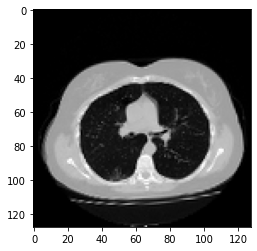

In [ ]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")


plotting 40 slices of a ct scan 3d image

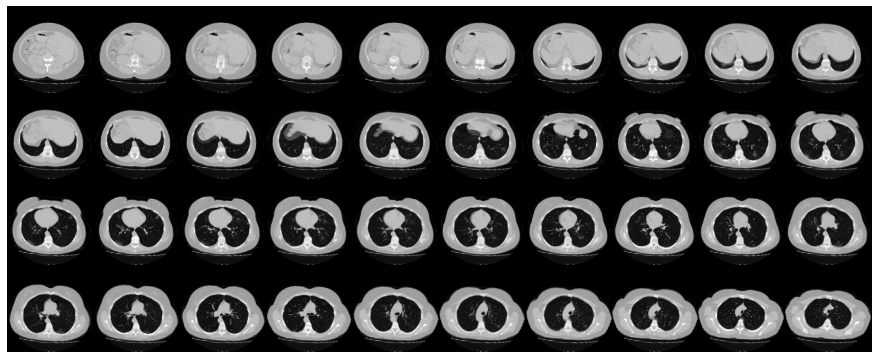

In [ ]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])


the convolution model 

In [ ]:
def get_model(width=128, height=128, depth=50):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=50)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 128, 128, 50, 1)  0         
                             ]                                   
                                                                 
 conv3d_16 (Conv3D)          (None, 126, 126, 48, 64)  1792      
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 63, 63, 24, 64)   0         
 g3D)                                                            
                                                                 
 batch_normalization_16 (Bat  (None, 63, 63, 24, 64)   256       
 chNormalization)                                                
                                                                 
 conv3d_17 (Conv3D)          (None, 61, 61, 22, 64)    110656    
                                                             

In [ ]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification1.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
70/70 - 20s - loss: 0.6863 - acc: 0.5786 - val_loss: 0.8494 - val_acc: 0.5000 - 20s/epoch - 287ms/step
Epoch 2/100
70/70 - 19s - loss: 0.6548 - acc: 0.6429 - val_loss: 0.7046 - val_acc: 0.5000 - 19s/epoch - 275ms/step
Epoch 3/100
70/70 - 19s - loss: 0.6284 - acc: 0.6571 - val_loss: 1.6406 - val_acc: 0.5000 - 19s/epoch - 271ms/step
Epoch 4/100
70/70 - 19s - loss: 0.6387 - acc: 0.6643 - val_loss: 0.8647 - val_acc: 0.5000 - 19s/epoch - 273ms/step
Epoch 5/100
70/70 - 19s - loss: 0.6236 - acc: 0.6571 - val_loss: 1.0234 - val_acc: 0.5000 - 19s/epoch - 271ms/step
Epoch 6/100
70/70 - 20s - loss: 0.5899 - acc: 0.6714 - val_loss: 1.1033 - val_acc: 0.5000 - 20s/epoch - 288ms/step
Epoch 7/100
70/70 - 19s - loss: 0.6089 - acc: 0.6643 - val_loss: 1.4108 - val_acc: 0.5000 - 19s/epoch - 272ms/step
Epoch 8/100
70/70 - 19s - loss: 0.5739 - acc: 0.6929 - val_loss: 1.1272 - val_acc: 0.5000 - 19s/epoch - 271ms/step
Epoch 9/100
70/70 - 19s - loss: 0.5643 - acc: 0.7500 - val_loss: 0.6123 - val_ac

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


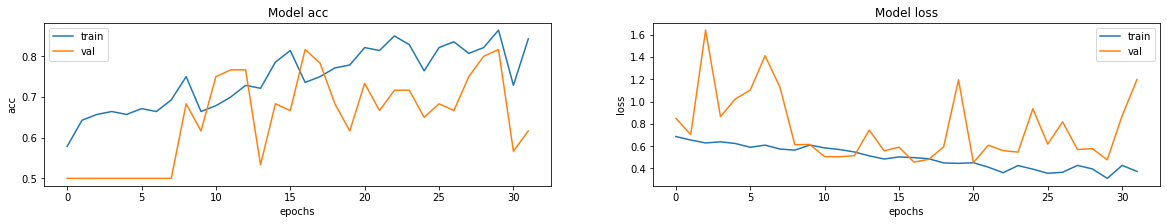

In [ ]:

fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

plt.savefig('lung_ct_scan.eps',
           dpi=300)

the best accuracy it created was 80 percent and the weights are saved based on that training

In [ ]:
# Load best weights.
model.load_weights("3d_image_classification.h5")
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

This model is 5.75 percent confident that CT scan is normal
This model is 94.25 percent confident that CT scan is abnormal


now we start with our own model,
lets mount the data from drive first

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now we start with the tooth

lets install the stl-to-voxel package to convert the data into voxels

In [ ]:
!pip install git+https://github.com/cpederkoff/stl-to-voxel.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cpederkoff/stl-to-voxel.git to /tmp/pip-req-build-gw2cmk6n
  Running command git clone -q https://github.com/cpederkoff/stl-to-voxel.git /tmp/pip-req-build-gw2cmk6n
  Created wheel for stl-to-voxel: filename=stl_to_voxel-0.9.2-py3-none-any.whl size=9168 sha256=40adcf7c4ecd2e670fac3a409d136b9d2e76ec6fd45f8950f9c0fd2a74dcea4c
  Stored in directory: /tmp/pip-ephem-wheel-cache-bj4m331w/wheels/d0/fe/4a/c290372124440511d3cf819155791e2f26e4603954304ccec0
Successfully built stl-to-voxel


we wrote a function stl_3d_processing, which is being used here to convert the voxels into image data

In [ ]:
from google.colab import files
src = list(files.upload().values())[0]
open('stl_3d_processing.py','wb').write(src)
import stl_3d_processing as sp

Saving stl_3d_processing.py to stl_3d_processing (1).py


import necessary packages

In [ ]:
import pandas as pd
import os
from tqdm.notebook import tqdm
import math
import numpy as np
import tensorflow as tf
import random

from scipy import ndimage

from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
setting the data directory

In [ ]:
data_dir = '/content/drive/MyDrive/The defects'

resolution = 64
resize_val = (128, 128)

In [ ]:
stl_files = os.listdir(data_dir)

inlay_stl = []
onlay_stl = []

for i in tqdm(range(len(stl_files))):
    if "(onlay)" in stl_files[i]:
        onlay = sp.array(data_dir + "/" + stl_files[i], resolution)
        onlay = np.transpose(onlay, (1, 2, 0))        
        onlay_stl.append(onlay)
        
    else:
        inlay = sp.array(data_dir + "/" + stl_files[i], resolution)
        inlay = np.transpose(inlay, (1, 2, 0))
        inlay_stl.append(inlay)

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
np.shape(inlay_stl)

(15, 128, 128, 50)

In [ ]:
inlay_labels = np.array([1 for _ in range(len(inlay_stl))])
onlay_labels = np.array([0 for _ in range(len(onlay_stl))])

In [ ]:
n = math.floor((len(inlay_stl)/100)*70)

x_train = np.concatenate((inlay_stl[:n], onlay_stl[:n]), axis=0)
y_train = np.concatenate((inlay_labels[:n], onlay_labels[:n]), axis=0)
x_val = np.concatenate((inlay_stl[n:], onlay_stl[n:]), axis=0)
y_val = np.concatenate((inlay_labels[n:], onlay_labels[n:]), axis=0)

print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 20 and 10.


In [ ]:
np.shape(x_train)
np.shape(x_val)

(10, 128, 128, 50)

In [ ]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

we preprocessed the data very similar to the ct scan data

In [ ]:
@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.int32)
    return augmented_volume

def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [ ]:
batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

viewing one of the voxels of the tooth

Dimension of the Stl file is: (128, 128, 50, 1)


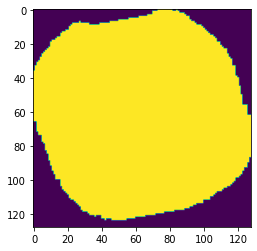

In [ ]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the Stl file is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 18]))
plt.savefig('random_defect_slice.eps',
           dpi=300)

we now load the original model we just trained

In [ ]:
from tensorflow import keras
trans_model = keras.models.load_model("/content/3d_image_classification.h5")
trans_model.summary()


Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 128, 128, 50, 1)  0         
                             ]                                   
                                                                 
 conv3d_12 (Conv3D)          (None, 126, 126, 48, 64)  1792      
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 63, 63, 24, 64)   0         
 g3D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 63, 63, 24, 64)   256       
 chNormalization)                                                
                                                                 
 conv3d_13 (Conv3D)          (None, 61, 61, 22, 64)    110656    
                                                             

freeze certain layers of the model and keep the rest trainable

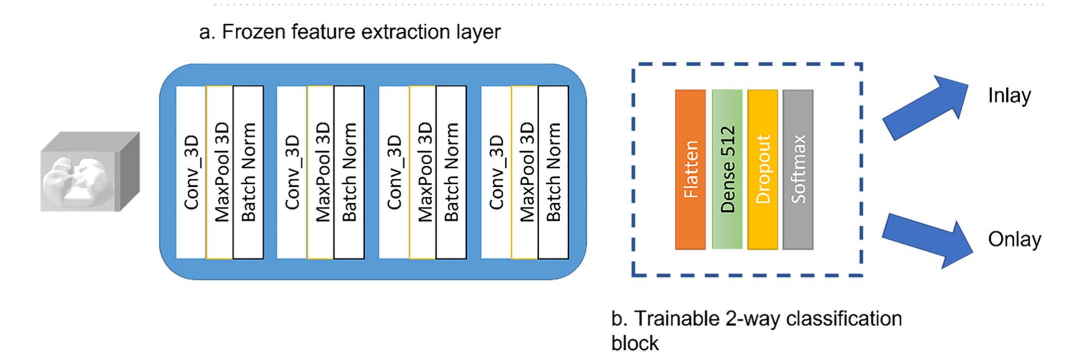

In [ ]:
for i in range(13):
    trans_model.layers[i].trainable = False

In [ ]:
for i in range(13,15):
    trans_model.layers[i].trainable = True

In [ ]:
len(trans_model.layers)
j = 4
for i in range(len(trans_model.layers) - j):
  print('layers to be to be frozen')
  print(i)
  trans_model.layers[i].trainable = False

for i in range(len(trans_model.layers) - j, len(trans_model.layers)):
  print('layers to be to be trained')
  print(i)
  trans_model.layers[i].trainable = True

layers to be to be frozen
0
layers to be to be frozen
1
layers to be to be frozen
2
layers to be to be frozen
3
layers to be to be frozen
4
layers to be to be frozen
5
layers to be to be frozen
6
layers to be to be frozen
7
layers to be to be frozen
8
layers to be to be frozen
9
layers to be to be frozen
10
layers to be to be frozen
11
layers to be to be frozen
12
layers to be to be trained
13
layers to be to be trained
14
layers to be to be trained
15
layers to be to be trained
16


In [ ]:
trans_model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 128, 128, 50, 1)  0         
                             ]                                   
                                                                 
 conv3d_12 (Conv3D)          (None, 126, 126, 48, 64)  1792      
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 63, 63, 24, 64)   0         
 g3D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 63, 63, 24, 64)   256       
 chNormalization)                                                
                                                                 
 conv3d_13 (Conv3D)          (None, 61, 61, 22, 64)    110656    
                                                             

In [ ]:
def get_model(width=128, height=128, depth=50):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.UpSampling3D(size=(1, 1, 1), data_format=None)(inputs)


    outputs = trans_model(x, training=False)
    
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model

transfer_model = get_model(width=128, height=128, depth=50)
transfer_model.summary()



Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 128, 128, 50, 1)  0         
                             ]                                   
                                                                 
 up_sampling3d_16 (UpSamplin  (None, 128, 128, 50, 1)  0         
 g3D)                                                            
                                                                 
 3dcnn (Functional)          (None, 1)                 1352897   
                                                                 
Total params: 1,352,897
Trainable params: 132,097
Non-trainable params: 1,220,800
_________________________________________________________________


In [ ]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
transfer_model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "stl_classification_defects.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
transfer_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
10/10 - 3s - loss: 4.1304 - acc: 0.5000 - val_loss: 2.4116 - val_acc: 0.5000 - 3s/epoch - 344ms/step
Epoch 2/100
10/10 - 3s - loss: 2.1271 - acc: 0.5000 - val_loss: 1.1445 - val_acc: 0.5000 - 3s/epoch - 263ms/step
Epoch 3/100
10/10 - 3s - loss: 0.8697 - acc: 0.6500 - val_loss: 0.9887 - val_acc: 0.5000 - 3s/epoch - 262ms/step
Epoch 4/100
10/10 - 3s - loss: 0.4610 - acc: 0.7000 - val_loss: 1.2644 - val_acc: 0.6000 - 3s/epoch - 257ms/step
Epoch 5/100
10/10 - 3s - loss: 0.4203 - acc: 0.8000 - val_loss: 1.1190 - val_acc: 0.6000 - 3s/epoch - 262ms/step
Epoch 6/100
10/10 - 3s - loss: 0.3214 - acc: 0.9500 - val_loss: 0.9710 - val_acc: 0.6000 - 3s/epoch - 260ms/step
Epoch 7/100
10/10 - 3s - loss: 0.2876 - acc: 0.9000 - val_loss: 0.8471 - val_acc: 0.6000 - 3s/epoch - 255ms/step
Epoch 8/100
10/10 - 3s - loss: 0.2951 - acc: 0.9000 - val_loss: 0.8747 - val_acc: 0.6000 - 3s/epoch - 260ms/step
Epoch 9/100
10/10 - 3s - loss: 0.2292 - acc: 0.9500 - val_loss: 0.8004 - val_acc: 0.6000 - 3s/ep

generate plots for train and validation accuracy and loss

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


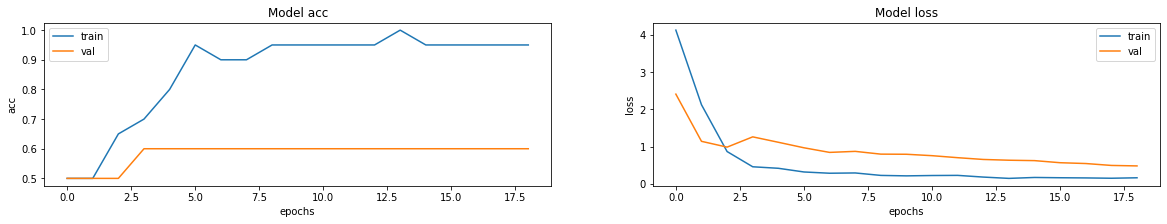

In [ ]:

fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(transfer_model.history.history[metric])
    ax[i].plot(transfer_model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

plt.savefig('defect_study_accuracy_and_loss.eps',
           dpi=300)

check the accuracy of a model with one of the random samples of the test set

In [ ]:
# Load best weights.
k = 4
transfer_model.load_weights("stl_classification_defects.h5")
prediction = model.predict(np.expand_dims(x_val[k], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["onlay", "inlay"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that target is %s"
        % ((100 * score), name)
    )

if y_val[k]==1:
  print("While the original label is inlay")
else:
  print("While the original label is onlay")

This model is 99.96 percent confident that target is onlay
This model is 0.04 percent confident that target is inlay
While the original label is inlay


checking the entire test set of the model

In [ ]:
for k in range(10):
  transfer_model.load_weights("stl_classification_defects.h5")
  prediction = model.predict(np.expand_dims(x_val[k], axis=0))[0]
  scores = [1 - prediction[0], prediction[0]]

  class_names = ["onlay", "inlay"]
  for score, name in zip(scores, class_names):
      print(
          "This model is %.2f percent confident that target is %s"
          % ((100 * score), name)
      )

  if y_val[k]==1:
    print("While the original label is inlay")
  else:
    print("While the original label is onlay")

This model is 100.00 percent confident that target is onlay
This model is 0.00 percent confident that target is inlay
While the original label is inlay
This model is 99.89 percent confident that target is onlay
This model is 0.11 percent confident that target is inlay
While the original label is inlay
This model is 99.93 percent confident that target is onlay
This model is 0.07 percent confident that target is inlay
While the original label is inlay
This model is 99.95 percent confident that target is onlay
This model is 0.05 percent confident that target is inlay
While the original label is inlay
This model is 99.96 percent confident that target is onlay
This model is 0.04 percent confident that target is inlay
While the original label is inlay
This model is 100.00 percent confident that target is onlay
This model is 0.00 percent confident that target is inlay
While the original label is onlay
This model is 99.82 percent confident that target is onlay
This model is 0.18 percent confid